In [2]:
%%capture
!pip install tensorflow
!pip install keras_tuner

In [3]:
%%capture
import pandas as pd 
import numpy as np 
import os
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

To start with,

I pulled the identical data with our group which is the call options price data. 
We will be using the features as, {close, strike, delta, gamma, vega, theta, implied volatility, time to maturity, moneyness}
I will be using the RandomForest model to predict the call option pricing. 

In [4]:
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Filter to Calls Only
full_df = full_df[full_df['type'] == "call"]
# Filter to every 10th row
full_df = full_df.iloc[::10]

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

## 1

Option prices are governed by highly non linear functions of multiple inputs, so I wanted to use the model that can handle these which was Random forests(RF). 
Random Forests build an ensemble of decision trees, each of which can split on feature thresholds in a nonlinear way and by averaging such trees, we can approximate the complex surface that maps the variables to the mid-price that we want.

The features of option pricing tends to interact each other such as the greeks and the implied volatility are correlated. When using the Random Forest, in the process of splitting trees, for example, first split on strike, then implied volatility and so on, the model can learn the pairwise interactions without manual feature setting, which seems to be a nice fit.

Also, RF do not require rigid scaling or normalization of the data so, it is quite simple when preprocessing data. 

The built in function of feature importance can also help us analyze which factors or which combination of factors explain the option pricing the most which can lead to future feature engineering. 

first, as a rule of thumb, I'll start with setting the parameters as following.

In [5]:
rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = None, 
    min_samples_leaf = 5,
    max_features = "sqrt",
    random_state = 42,
    n_jobs= -1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

## 2

To start with, I set the baseline as a common trivial regression, predicting the training set mean. 
The reason why I used the mean of training set is because since we are comparing with a model learning with the "train set", we need to make sure there is no leak of information from the validation or test set. 

then tried to simply compare the MAE, RMSE with the validaiton set.

The result shows a lot more smaller values on both, which we can at least know that the RF regressor is extracting some real structure beyond just average prices.

In [6]:
#baseline

base_pred = np.full_like(y_valid, fill_value = np.mean(y_train))
mae_base = mean_absolute_error(y_valid, base_pred)
rmse_base = mean_squared_error(y_valid, base_pred, squared=False)

print(f"the baseline mae : {mae_base:.4f}")
print(f"the baseline rmse : {rmse_base:.4f}")

y_valid_pred = rf.predict(X_valid)

mae_valid = mean_absolute_error(y_valid, y_valid_pred)
rmse_valid = mean_squared_error(y_valid, y_valid_pred, squared=False)

print(f"the valid set mae:{mae_valid:.4f}")
print(f"the valid set rmse:{rmse_valid:.4f}")

the baseline mae : 27.5750
the baseline rmse : 54.1754
the valid set mae:1.7730
the valid set rmse:5.6227


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 3

this time, I tried to fix other hyperparameters except max depth to see which shows better performance.

I will be doing the sequential tuning since if we use the GridSearchCV, cannot guarantee how much computing time it will take. 

I started with the max_depth since I thought it can give me the sense at which point of the max_depth that the model converts from underfitting to overfitting.

As you can see the result below, the loss seems to move meaningfully between depth= 15, 20 and furthermore is pretty much same. So I will be trying to test depth (15,) 20 for further hyperparameter tuning. 

In [7]:
for depth in [5, 10, 15, 20]:
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    valid_pred = rf.predict(X_valid)

    train_loss = mean_squared_error(y_train, train_pred)    
    valid_loss = mean_squared_error(y_valid, valid_pred)    

    print(f"depth={depth}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}")

depth=5, train_loss=131.4372, valid_loss=126.2542
depth=10, train_loss=4.6226, valid_loss=7.3822
depth=15, train_loss=0.9250, valid_loss=3.6396
depth=20, train_loss=0.8503, valid_loss=3.5389


In [8]:
for depth in [25, None]:
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    valid_pred = rf.predict(X_valid)

    train_loss = mean_squared_error(y_train, train_pred)    
    valid_loss = mean_squared_error(y_valid, valid_pred)    

    print(f"depth={depth}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}")

depth=25, train_loss=0.8476, valid_loss=3.5539
depth=None, train_loss=0.8391, valid_loss=3.5845


## 3 - 1

I'll fix the max_depth = 20 and try the loop for n_estimators [50, 100, 150] and min_samples_leaf [5, 10] and see the best hyperparameters.

Looking at the result below, we can see that best hyperparameters with our set would be, n_estimators : 100, min_samples_leaf : 5, max_depth : 20.

In [9]:
results = []

n_list = [50, 100, 150]
leaf_list = [5, 10]

for n in n_list:
    for leaf in leaf_list:
        rf = RandomForestRegressor(
            n_estimators = n,
            max_depth = 20,
            min_samples_leaf = leaf,
            max_features = "sqrt",
            random_state = 42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_valid)
        val_mse = mean_squared_error(y_valid, y_val_pred)
        results.append({
            "n_est": n,
            "min_samples_leaf":leaf,
            "val_mse": val_mse
        })

df_results = pd.DataFrame(results)
print(df_results)

   n_est  min_samples_leaf    val_mse
0     50                 5  32.135577
1     50                10  50.220495
2    100                 5  31.097820
3    100                10  46.007973
4    150                 5  31.775086
5    150                10  44.761536


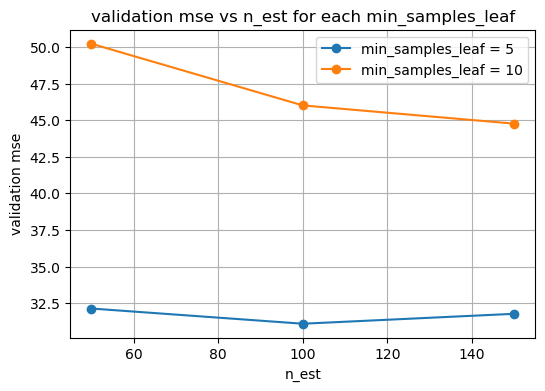

In [10]:
plt.figure(figsize=(6,4))

for leaf in leaf_list:
    subset = df_results[df_results["min_samples_leaf"] == leaf]
    subset = subset.sort_values("n_est")
    plt.plot(
        subset["n_est"],
        subset["val_mse"],
        marker="o",
        label = f"min_samples_leaf = {leaf}"
    )

plt.xlabel("n_est")
plt.ylabel("validation mse")
plt.title("validation mse vs n_est for each min_samples_leaf")
plt.grid(True)
plt.legend()
plt.show()

## 4

with the best hyperparameters we got, I updated the RF Regressor again.
since we finished the tuning for hyper parameters, we trained it with the train+valid data.

Then I computed the mae, rmse for the test data and it was almost the same as the result of valid data with the previous regressor. 
The scatter plot with the predict and the test set quite shows a linear relation which seems nice. 

In [11]:
final_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth = 20,
    min_samples_leaf = 5,
    max_features = "sqrt",
    random_state=42,
    n_jobs=-1
)

X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf.fit(X_train_full, y_train_full)


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      n_jobs=-1, random_state=42)

1.6712775795344321
5.741325256623565


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


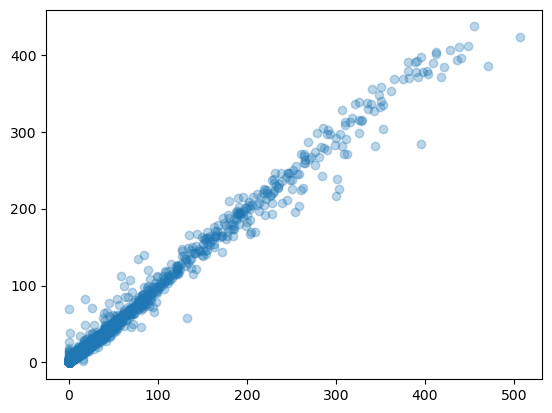

In [13]:
y_test_pred = final_rf.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# r2_test = r2_score(y_test, y_test_pred)

print(mae_test)
print(rmse_test)
# print(r2_test)

plt.scatter(y_test, y_test_pred, alpha=0.3)

## 4 - 1

I checked the feature importance to see which factors is the most influential.

It looks like the Close, Strike, Delta are the first three factors, with high feature importance.

close: 0.2864
strike: 0.2347
delta: 0.2210
gamma: 0.0841
implied_volatility: 0.0539
theta: 0.0534
tte: 0.0386
vega: 0.0280


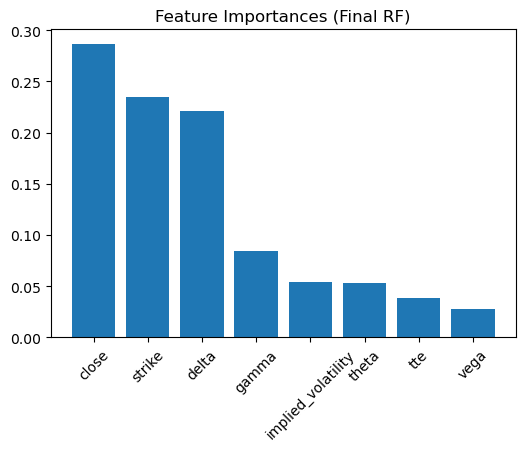

In [14]:
importances_final = final_rf.feature_importances_
feature_names = X_train.columns  
indices = np.argsort(importances_final)[::-1]
for idx in indices:
    print(f"{feature_names[idx]}: {importances_final[idx]:.4f}")


plt.figure(figsize=(6, 4))
plt.bar(range(len(importances_final)), importances_final[indices], align="center")
plt.xticks(range(len(importances_final)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importances (Final RF)")
plt.show()


## 4 - 2
Here, based on the importance feature above, I did the plot for the residuals according to each main factors. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


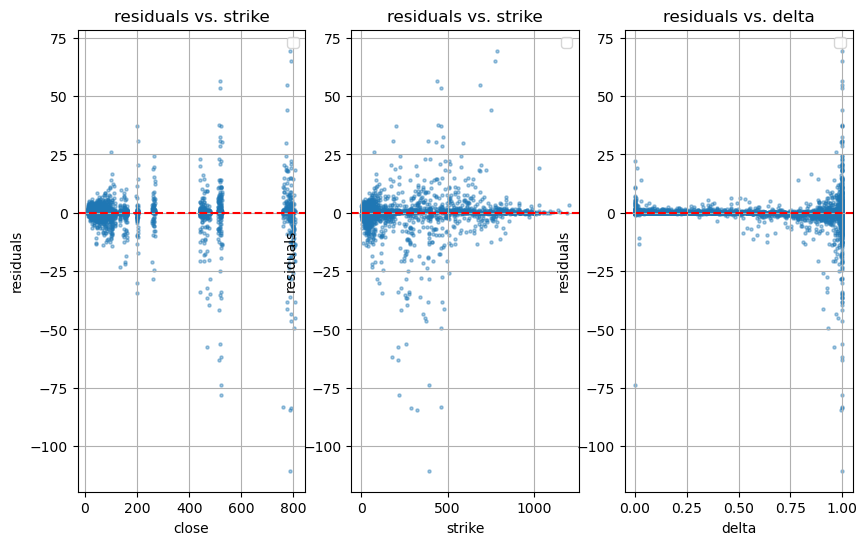

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))

residuals_test = y_test_pred - y_test
# ax1.hist(residuals_test, bins=50)
# ax1.set_xlabel("prediction error")
# ax1.set_ylabel("frequency")
# ax1.grid(True)
# ax1.legend()

ax1.scatter(X_test["close"], residuals_test, s=5, alpha=0.4)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("residuals vs. strike")
ax1.set_xlabel("close")
ax1.set_ylabel("residuals")
ax1.grid(True)
ax1.legend()

ax2.scatter(X_test["strike"], residuals_test, s=5, alpha=0.4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title("residuals vs. strike")
ax2.set_xlabel("strike")
ax2.set_ylabel("residuals")
ax2.grid(True)
ax2.legend()

ax3.scatter(X_test["delta"], residuals_test, s=5, alpha=0.4)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title("residuals vs. delta")
ax3.set_xlabel("delta")
ax3.set_ylabel("residuals")
ax3.grid(True)
ax3.legend()

plt.show()

for the close plot, we can know that we are missing some range of close call prices and the residuals tend to have smaller variance among the smaller close prices which would be because the majority of data is densed there so it is trained well.

for the strike plot, it shows quite steady and dense scatter among strike price of 100~200 and 800~1000. The residuals among strike price of 200~500 shows some negative values whereas it shows positive residuals for the positive strikes. For the former the price tends to be underestimated, the latter overestimated. 

for the delta plot, the residuals seem to pike as it gets bigger and there is a steady residuals around zero among 0.1 to 0.5. For this, we can think of some reasons. It might be because of the trading volume is more concentratd around 0.3 to 0.6. With relatively small data, RF tends to overfit the sparse, noisy examples which produces higher variance. Also, at the tails, the bid ask spreads can be large so since we are using the mid price for our y data, mid prices can be jumped and the plot shows high variance. 

## 4 - 3
learning curves.
As the result below, the learning curve shows some significant elbow since around train data of 5000 to 7500. 
The mse of train and validation tends to converge each other but still the value is large. 
we can think that with a larger train data set, it prevents some overfitting, but also it can be interpreted as still got some overfitting issue with the data around 19000. 
Therefore, we can try with a bigger dataset or try to optimize the hyperparameters more tightly to get a better regressor. 

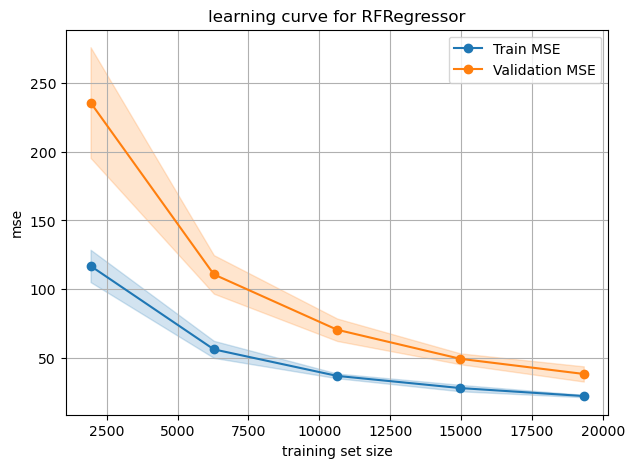

In [17]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

cv = KFold(n_splits = 5, shuffle=True, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator = final_rf,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = cv,
    scoring= "neg_mean_squared_error",
    n_jobs=-1,
    shuffle=True,
    random_state = 42
)

train_mse_mean = -train_scores.mean(axis=1)
train_mse_std = train_scores.std(axis=1)
valid_mse_mean = -valid_scores.mean(axis=1)
valid_mse_std = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.fill_between(
    train_sizes,
    train_mse_mean - train_mse_std,
    train_mse_mean + train_mse_std,
    alpha=0.2,
    color="C0"
)
plt.fill_between(
    train_sizes,
    valid_mse_mean - valid_mse_std,
    valid_mse_mean + valid_mse_std,
    alpha=0.2,
    color="C1"
)

plt.plot(train_sizes, train_mse_mean, "o-", color="C0", label="Train MSE")
plt.plot(train_sizes, valid_mse_mean, "o-", color="C1", label="Validation MSE")
plt.xlabel("training set size")
plt.ylabel("mse")
plt.title("learning curve for RFRegressor")
plt.legend(loc="best")
plt.grid(True)
plt.show()

below, I tried to make a more rigid hyperparameter test with,
any integer from 50 to 200,
various max depth,
any integer from 5 to 30,
varying max features,
and trying 30 random combinations while RandomizedSearchCV.

The best hyperparameter combination differed as final_rf so I tried to apply it to see the different result but the tendency seemed similar while there was a quite reduction in the rmse of the test, validation both. 

In [ ]:
param_dist = {
    "n_estimators":    st.randint(50, 201),    # any integer from 50 to 200
    "max_depth":       [8, 10, 12, 15, 20, None],
    "min_samples_leaf": st.randint(5, 31),     # any integer from 5 to 30
    "max_features":    ["sqrt", "log2", 2, 3]  # either of these strings or ints
}

rand_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,               # to try 30 random combinations
    scoring="neg_mean_squared_error",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
print("Best Randomized params:", rand_search.best_params_)
best_rf = rand_search.best_estimator_

Best Randomized params: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 6, 'n_estimators': 63}


In [19]:
final_rf_2 = RandomForestRegressor(
    n_estimators=63,
    max_depth = 10,
    min_samples_leaf = 6,
    max_features = 3,
    random_state=42,
    n_jobs=-1
)

X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf_2.fit(X_train_full, y_train_full)

RandomForestRegressor(max_depth=10, max_features=3, min_samples_leaf=6,
                      n_estimators=63, n_jobs=-1, random_state=42)

2.0453741618079784
5.670681444271569


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


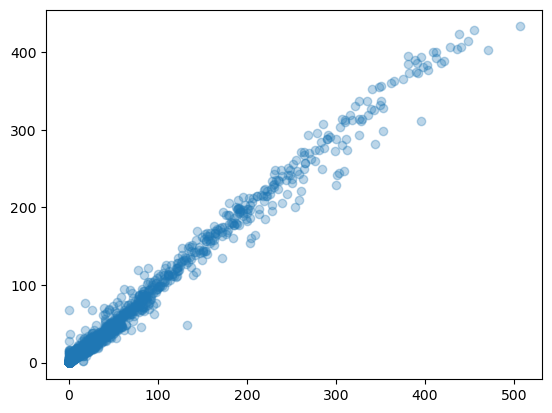

In [20]:
y_test_pred_2 = final_rf_2.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred_2)
rmse_test = mean_squared_error(y_test, y_test_pred_2, squared=False)
# r2_test = r2_score(y_test, y_test_pred)

print(mae_test)
print(rmse_test)
# print(r2_test)

plt.scatter(y_test, y_test_pred_2, alpha=0.3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


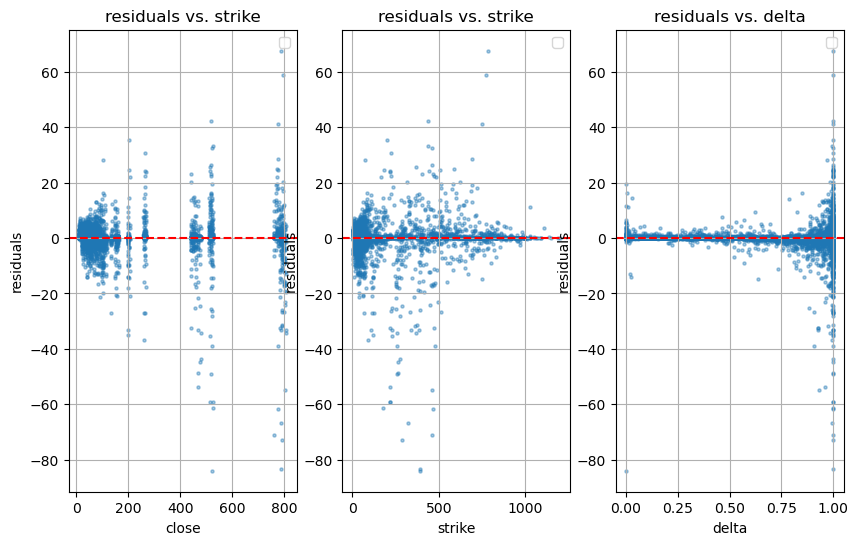

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))

residuals_test2 = y_test_pred_2 - y_test
# ax1.hist(residuals_test, bins=50)
# ax1.set_xlabel("prediction error")
# ax1.set_ylabel("frequency")
# ax1.grid(True)
# ax1.legend()

ax1.scatter(X_test["close"], residuals_test2, s=5, alpha=0.4)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("residuals vs. strike")
ax1.set_xlabel("close")
ax1.set_ylabel("residuals")
ax1.grid(True)
ax1.legend()

ax2.scatter(X_test["strike"], residuals_test2, s=5, alpha=0.4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title("residuals vs. strike")
ax2.set_xlabel("strike")
ax2.set_ylabel("residuals")
ax2.grid(True)
ax2.legend()

ax3.scatter(X_test["delta"], residuals_test2, s=5, alpha=0.4)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title("residuals vs. delta")
ax3.set_xlabel("delta")
ax3.set_ylabel("residuals")
ax3.grid(True)
ax3.legend()

plt.show()

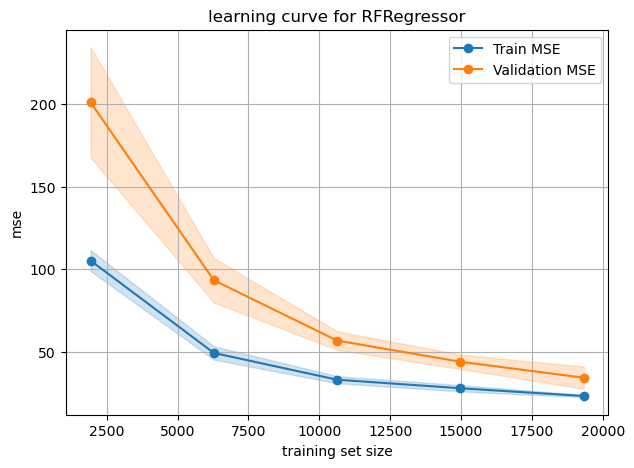

In [22]:
cv = KFold(n_splits = 5, shuffle=True, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator = final_rf_2,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = cv,
    scoring= "neg_mean_squared_error",
    n_jobs=-1,
    shuffle=True,
    random_state = 42
)

train_mse_mean = -train_scores.mean(axis=1)
train_mse_std = train_scores.std(axis=1)
valid_mse_mean = -valid_scores.mean(axis=1)
valid_mse_std = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.fill_between(
    train_sizes,
    train_mse_mean - train_mse_std,
    train_mse_mean + train_mse_std,
    alpha=0.2,
    color="C0"
)
plt.fill_between(
    train_sizes,
    valid_mse_mean - valid_mse_std,
    valid_mse_mean + valid_mse_std,
    alpha=0.2,
    color="C1"
)

plt.plot(train_sizes, train_mse_mean, "o-", color="C0", label="Train MSE")
plt.plot(train_sizes, valid_mse_mean, "o-", color="C1", label="Validation MSE")
plt.xlabel("training set size")
plt.ylabel("mse")
plt.title("learning curve for RFRegressor")
plt.legend(loc="best")
plt.grid(True)
plt.show()